# Loading libraries

In [1]:
from typing import List, Union, Dict
import sys
import os
import glob
import datetime
import yaml
import warnings
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna
import datetime

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from statsforecast.models import AutoARIMA

from data_formatter.base import *
from bin.utils import *

# Covariates processing

## Load Glucose data

In [2]:
# Loop over the folder of each subject and merge files with insulin data by id
subject_ids = ["001", "002", "003", "004", "005", "006", "007", "008", "009"]

df_list = []
for subject_id in subject_ids:
    subject_data = pd.read_csv(f"raw_data/dubosson_covariates/diabetes_subset_pictures-glucose-food-insulin/{subject_id}/glucose.csv")
    subject_data["id"] = subject_id
    df_list.append(subject_data)

glucose_data = pd.concat(df_list, axis=0, ignore_index=True)
glucose_data

,date,time,glucose,type,comments,id
0,2014-10-01,19:14:00,10.3,cgm,NaN,001
1,2014-10-01,19:19:00,9.9,cgm,NaN,001
2,2014-10-01,19:23:00,9.4,manual,NaN,001
3,2014-10-01,19:24:00,9.8,cgm,NaN,001
4,2014-10-01,19:29:00,9.6,cgm,NaN,001
...,...,...,...,...,...,...
8216,2014-10-04,09:00:00,5.6,manual,NaN,009
8217,2014-10-04,12:45:00,6.4,manual,NaN,009
8218,2014-10-04,16:00:00,6.9,manual,NaN,009
8219,2014-10-04,19:00:00,6.9,manual,NaN,009


In [3]:
# Create one daytime column 
glucose_data['date'] = pd.to_datetime(glucose_data['date'])
glucose_data['time'] = pd.to_datetime(glucose_data['time'], format='%H:%M:%S').dt.time
glucose_data['time'] = glucose_data.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
# Keep the observations with cgm type only
glucose_data = glucose_data[(glucose_data['type']=='cgm')]
# Drop Date, Type, Comments columns
glucose_data.drop(["date", "type", "comments"], axis=1, inplace=True)
# Covert subject ids to int64 to match with "data" ids
glucose_data['id'] = glucose_data['id'].astype(int)
# Check for NaNs
glucose_data.isna().sum() # no NaN values
# Convert glucose readings from mmol/l to mg/dl
glucose_data['glucose'] = 18*glucose_data['glucose']
# rename Glucose column to gl
glucose_data.rename(columns={'glucose': 'gl'}, inplace=True)
# Reorder the columns
glucose_data = glucose_data[['id', 'time', 'gl']]
# reset index
glucose_data.reset_index(drop=True, inplace=True)

glucose_data

,id,time,gl
0,1,2014-10-01 19:14:00,185.4
1,1,2014-10-01 19:19:00,178.2
2,1,2014-10-01 19:24:00,176.4
3,1,2014-10-01 19:29:00,172.8
4,1,2014-10-01 19:34:00,169.2
...,...,...,...
8050,9,2014-10-03 12:20:19,88.2
8051,9,2014-10-03 12:25:19,75.6
8052,9,2014-10-03 12:30:19,59.4
8053,9,2014-10-03 12:35:19,48.6


## Insulin covariates

In [4]:
# Loop over the folder of each subject and merge files with insulin data by id
subject_ids = ["001", "002", "003", "004", "005", "006", "007", "008", "009"]

df_list = []
for subject_id in subject_ids:
    subject_data = pd.read_csv(f"raw_data/dubosson_covariates/diabetes_subset_pictures-glucose-food-insulin/{subject_id}/insulin.csv")
    subject_data["id"] = subject_id
    df_list.append(subject_data)

insulin_data = pd.concat(df_list, axis=0, ignore_index=True)
insulin_data

,date,time,fast_insulin,slow_insulin,comment,id
0,2014-10-01,10:06:00,7.0,NaN,NaN,001
1,2014-10-01,16:50:00,4.0,NaN,NaN,001
2,2014-10-01,19:28:00,6.0,NaN,NaN,001
3,2014-10-01,22:27:00,8.0,NaN,NaN,001
4,2014-10-01,23:48:00,0.0,31.0,NaN,001
...,...,...,...,...,...,...
121,2014-10-03,22:00:00,NaN,18.0,NaN,009
122,2014-10-04,06:00:00,3.0,NaN,NaN,009
123,2014-10-04,12:00:00,4.0,NaN,NaN,009
124,2014-10-04,19:00:00,4.0,NaN,NaN,009


In [5]:
# Create one daytime column 
insulin_data['date'] = pd.to_datetime(insulin_data['date'])
insulin_data['time'] = pd.to_datetime(insulin_data['time'], format='%H:%M:%S').dt.time
insulin_data['datetime'] = insulin_data.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
# Drop Date, Time, Comment columns
insulin_data.drop(["date", "time", "comment"], axis=1, inplace=True)
# Covert subject ids to int64 to match with "data" ids
insulin_data['id'] = insulin_data['id'].astype(int)

insulin_data

,fast_insulin,slow_insulin,id,datetime
0,7.0,NaN,1,2014-10-01 10:06:00
1,4.0,NaN,1,2014-10-01 16:50:00
2,6.0,NaN,1,2014-10-01 19:28:00
3,8.0,NaN,1,2014-10-01 22:27:00
4,0.0,31.0,1,2014-10-01 23:48:00
...,...,...,...,...
121,NaN,18.0,9,2014-10-03 22:00:00
122,3.0,NaN,9,2014-10-04 06:00:00
123,4.0,NaN,9,2014-10-04 12:00:00
124,4.0,NaN,9,2014-10-04 19:00:00


In [6]:
# Merge the two datasets based on "id"
df = insulin_data.merge(glucose_data, on='id')
# For each row in insulin_data, calculate the absolute difference
df['diff'] = (df['datetime'] - df['time']).abs()
# Find the index of the minimum difference for each subject and each insulin date-time
idx = df.groupby(['id', 'datetime'])['diff'].idxmin()
# Use that index to retrieve the corresponding "time" value
df_final = df.loc[idx, ['id', 'datetime', 'time']]
df_final.rename(columns={'id': 'id', 'time': 'closest_time'}, inplace=True)
# Add the closest time as a new column in insulin_data
result = insulin_data.merge(df_final, on=['id', 'datetime'], how='left')
# Calculate the difference between the closest time and datetime in minutes
result.loc[:, 'time_diff'] = np.abs((result['closest_time'] - result['datetime']) / np.timedelta64(1, 'm'))
# Keep only the rows where the absolute difference is less than or equal to 5 minutes
result = result.loc[result['time_diff'] <= 5, :]
# Some rows have exact the same closest_time when a person took fast and slow insulin at the same time. 
# Merge these duplicate rows in one row
result = result.groupby(["id", "closest_time"]).agg({"fast_insulin": "sum", "slow_insulin": "sum"}).reset_index()
# Merge glucose and insulin datasets
data_cov = glucose_data.merge(result, how='left', left_on=['id', 'time'], right_on=['id', 'closest_time'])
# Drop closest_time column
data_cov.drop(["closest_time"], axis=1, inplace=True)
# Replace observed values of zeroes with NaN
data_cov = data_cov.replace(0, np.nan)

data_cov

,id,time,gl,fast_insulin,slow_insulin
0,1,2014-10-01 19:14:00,185.4,NaN,NaN
1,1,2014-10-01 19:19:00,178.2,NaN,NaN
2,1,2014-10-01 19:24:00,176.4,NaN,NaN
3,1,2014-10-01 19:29:00,172.8,6.0,NaN
4,1,2014-10-01 19:34:00,169.2,NaN,NaN
...,...,...,...,...,...
8050,9,2014-10-03 12:20:19,88.2,NaN,NaN
8051,9,2014-10-03 12:25:19,75.6,NaN,NaN
8052,9,2014-10-03 12:30:19,59.4,NaN,NaN
8053,9,2014-10-03 12:35:19,48.6,NaN,NaN


In [7]:
## Prepare data for the interpolation

# set NaN right before observed values to 0 for slow_insulin
mask = data_cov['slow_insulin'].isna() & data_cov['slow_insulin'].shift(-1).notna()
data_cov.loc[mask, 'slow_insulin'] = 0
# set NaN right before observed values to 0 for fast_insulin
mask = data_cov['fast_insulin'].isna() & data_cov['fast_insulin'].shift(-1).notna()
data_cov.loc[mask, 'fast_insulin'] = 0

# Insert 0 instead of NaN in slow_insulin after approx. 24 hours after last observation or at the very last observation for each subject
subset_data = []
for id in data_cov['id'].unique():
    # select only the rows for the current id
    id_data_cov = data_cov[data_cov['id']==id]
    # Find index of the last observed value
    last_observed_index = id_data_cov['slow_insulin'].last_valid_index()
    # If there are no observed values at all, insert 0 to the last observation of the subset
    if pd.isna(last_observed_index):
        slow_insulin = id_data_cov['slow_insulin'].copy()
        id_data_cov.loc[id_data_cov.index[-1], 'slow_insulin'] = 0 
    else:
        # Insert 0 instead of NaN in slow_insulin after approx. 24 hours after last valis observation
        id_data_cov.loc[last_observed_index + 228, 'slow_insulin'] = 0
    # Append the subjects' subsets
    subset_data.append(id_data_cov)
# Covert the data back to dataframe  
data_cov = pd.concat(subset_data, ignore_index=True)

# Insert 0 instead of NaN in fast_insulin after approx. 2 hours after last observation or at the very last observation for each subject
subset_data = []
for id in data_cov['id'].unique():
    # select only the rows for the current id
    id_data_cov = data_cov[data_cov['id']==id]
    # Find index of the last observed value
    last_observed_index = id_data_cov['fast_insulin'].last_valid_index()
    # If there are no observed values at all, insert 0 to the last observation of the subset
    if pd.isna(last_observed_index):
        slow_insulin = id_data_cov['fast_insulin'].copy()
        id_data_cov.loc[id_data_cov.index[-1], 'fast_insulin'] = 0 
    else:
        # Insert 0 instead of NaN in slow_insulin after approx. 24 hours after last valis observation
        id_data_cov.loc[last_observed_index + 24, 'fast_insulin'] = 0
    # Append the subjects' subsets
    subset_data.append(id_data_cov)
# Covert the data back to dataframe  
data_cov = pd.concat(subset_data, ignore_index=True)

In [8]:
## Interpolate insulin data

# Sort the data by subject ID and time
data = data_cov.sort_values(['id', 'time'])
interpolated_data = []

# Loop over each subject ID
for subject_id in data['id'].unique():
    # Select the rows for the current subject ID
    subject_data = data[data['id'] == subject_id]
    
    subject_data['slow_insulin'] = subject_data['slow_insulin'].interpolate(
        method='linear', limit_area = 'inside')
    subject_data['fast_insulin'] = subject_data['fast_insulin'].interpolate(
        method='linear', limit_area = 'inside')
    interpolated_data.append(subject_data)

data_cov = pd.concat(interpolated_data, ignore_index=True)
# Replace NaN with zeroes
data_cov = data_cov.fillna(0)

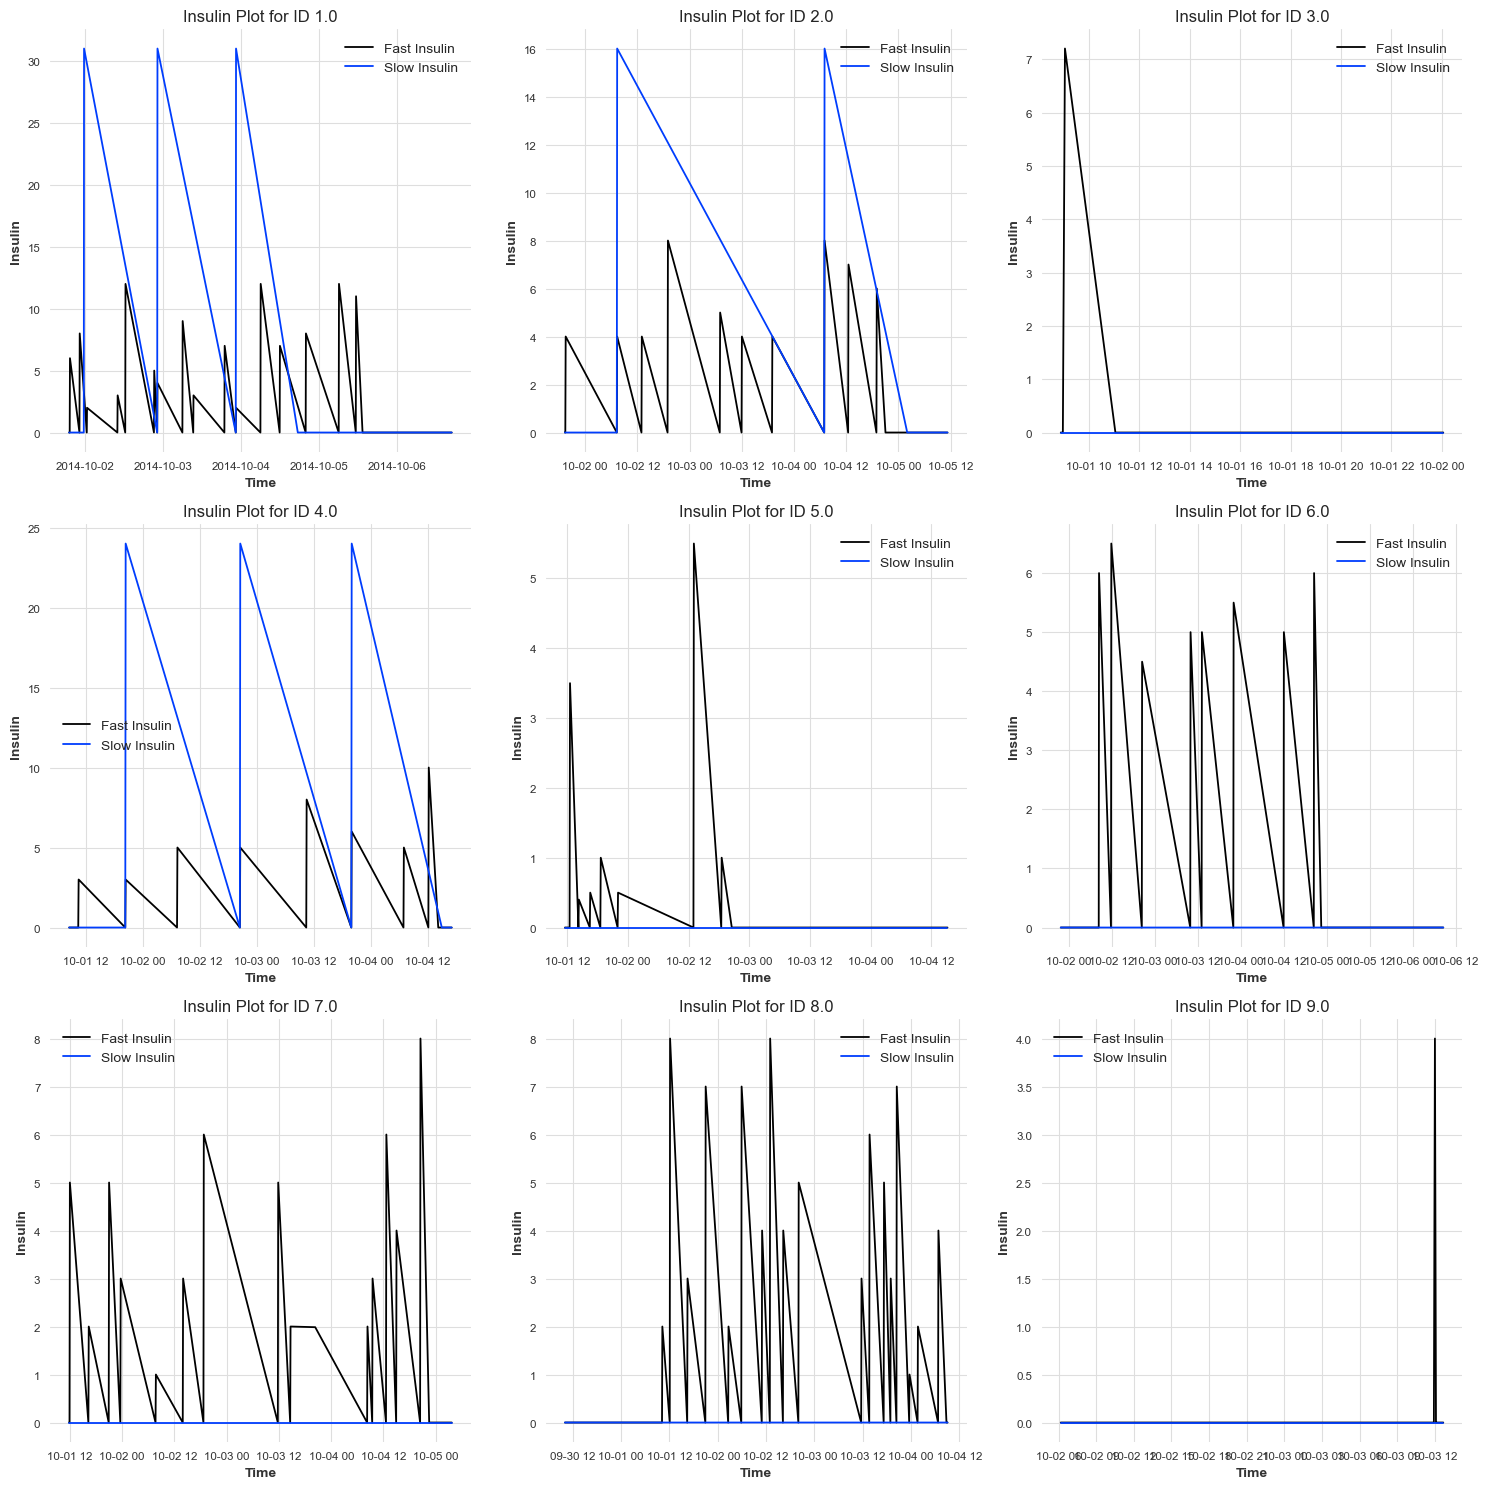

In [9]:
# Plot the fast and slow insulin intakes for each subject
groups = data_cov.groupby('id')
num_cols = 3
num_rows = int(np.ceil(len(groups)/num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, (group_name, group) in enumerate(groups):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]
    ax.plot(group['time'], group['fast_insulin'], label='Fast Insulin')
    ax.plot(group['time'], group['slow_insulin'], label='Slow Insulin')
    ax.set_xlabel('Time')
    ax.set_ylabel('Insulin')
    ax.set_title(f'Insulin Plot for ID {group_name}')
    ax.legend()

# Hide unused subplots
for i in range(len(groups), num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Sum of NaN values in dataset
data_cov.isna().sum().sum()

0

In [11]:
# Summary statistic of dataset
data_cov.describe()

,id,gl,fast_insulin,slow_insulin
count,8055.000000,8055.000000,8055.000000,8055.000000
mean,4.626195,165.712626,1.796418,3.509001
std,2.492887,76.026814,2.087314,6.840647
min,1.000000,39.600000,0.000000,0.000000
25%,2.000000,109.800000,0.000000,0.000000
50%,5.000000,154.800000,1.088235,0.000000
75%,7.000000,205.200000,2.924551,3.441520
max,9.000000,399.600000,12.000000,31.000000


## Food Data

In [12]:
# Loop over the folder of each subject and merge files with insulin data by id
subject_ids = ["001", "002", "003", "004", "005", "006", "007", "008", "009"]

df_list = []
for subject_id in subject_ids:
    subject_data = pd.read_csv(f"raw_data/dubosson_covariates/diabetes_subset_pictures-glucose-food-insulin/{subject_id}/food.csv")
    subject_data["id"] = subject_id
    df_list.append(subject_data)

food_data = pd.concat(df_list, axis=0, ignore_index=True)
food_data

,picture,description,calories,balance,quality,datetime,id
0,001.jpg,Iceberg lettuce with olive oil and vinegar,357.0,Unbalance,Good quality,2014:10:01 19:27:49,001
1,002.jpg,"Tuna salade with boiled egg, asiago cheese an...",866.0,Unbalance,Good quality,2014:10:01 19:32:00,001
2,003.jpg,Asiago cheese,190.0,Unbalance,Good quality,2014:10:01 19:43:59,001
3,004.jpg,"Lemon yogurt, asiago cheese and bread with kiwi",1063.0,Balance,Good quality,2014:10:02 10:11:16,001
4,005.jpg,Tomatoes with cheese and bread,979.0,Unbalance,Good quality,2014:10:02 19:34:03,001
...,...,...,...,...,...,...,...
110,007.jpg,"Boiled rice with carrots, coliflower, can corn...",567.0,Unbalance,Medium quality,2014:10:04 20:02:24,009
111,008.jpg,"Carrot soup, grilled sausages and ham pizza",654.0,Unbalance,Low quality,2014:10:05 12:44:46,009
112,009.jpg,"Chicken leg grilled, pork and potatoes chips a...",894.0,Unbalance,Low quality,2014:10:05 20:14:07,009
113,010.jpg,"Milk,toast and babybel cheese",218.0,Unbalance,Medium quality,2014:10:06 09:16:42,009


In [13]:
# Drop Picture, Description columns
food_data.drop(["picture", "description"], axis=1, inplace=True)
# Covert subject ids to int64 to match with "data" ids
food_data['id'] = food_data['id'].astype(int)
# Check for NaNs
food_data.isna().sum() #present
# Drop rows with NaN values
food_data.dropna()
# drop rows with NaN values in datetime column
food_data = food_data.dropna(subset=['datetime'])
# drop rows with NaN values in balance column
food_data = food_data.dropna(subset=['balance'])
# drop rows with NaN values in quality column
food_data = food_data.dropna(subset=['quality'])
# Change the format of datetime column to match with glucose dataset
food_data['datetime'] = food_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y:%m:%d %H:%M:%S'))


food_data

,calories,balance,quality,datetime,id
0,357.0,Unbalance,Good quality,2014-10-01 19:27:49,1
1,866.0,Unbalance,Good quality,2014-10-01 19:32:00,1
2,190.0,Unbalance,Good quality,2014-10-01 19:43:59,1
3,1063.0,Balance,Good quality,2014-10-02 10:11:16,1
4,979.0,Unbalance,Good quality,2014-10-02 19:34:03,1
...,...,...,...,...,...
110,567.0,Unbalance,Medium quality,2014-10-04 20:02:24,9
111,654.0,Unbalance,Low quality,2014-10-05 12:44:46,9
112,894.0,Unbalance,Low quality,2014-10-05 20:14:07,9
113,218.0,Unbalance,Medium quality,2014-10-06 09:16:42,9


In [14]:
# Get data summary
print(food_data['calories'].describe())
print(list(set(list(food_data['balance']))))
print(list(set(list(food_data['quality']))))

count     104.000000
mean      570.759615
std       391.313335
min        42.000000
25%       262.000000
50%       496.500000
75%       757.750000
max      2303.000000
Name: calories, dtype: float64
['Balance', 'Unbalance']
['Medium quality', 'Low quality', 'Good quality']


In [15]:
# Recode the binary/categorical values
food_data['balance'] = food_data['balance'].replace({'Unbalance': 1, 'Balance': 2})
food_data['quality'] = food_data['quality'].replace({'Low quality': 1, 'Medium quality': 2, 'Good quality': 3})
food_data

,calories,balance,quality,datetime,id
0,357.0,1,3,2014-10-01 19:27:49,1
1,866.0,1,3,2014-10-01 19:32:00,1
2,190.0,1,3,2014-10-01 19:43:59,1
3,1063.0,2,3,2014-10-02 10:11:16,1
4,979.0,1,3,2014-10-02 19:34:03,1
...,...,...,...,...,...
110,567.0,1,2,2014-10-04 20:02:24,9
111,654.0,1,1,2014-10-05 12:44:46,9
112,894.0,1,1,2014-10-05 20:14:07,9
113,218.0,1,2,2014-10-06 09:16:42,9


In [16]:
# Merge the two datasets based on "id"
df = data_cov.merge(food_data, on='id')
# For each row in insulin_data, calculate the absolute difference
df['diff'] = (df['datetime'] - df['time']).abs()
# Find the index of the minimum difference for each subject and each insulin date-time
idx = df.groupby(['id', 'datetime'])['diff'].idxmin()
# Use that index to retrieve the corresponding "time" value
df_final = df.loc[idx, ['id', 'datetime', 'time', 'calories', 'balance', 'quality']]
df_final.rename(columns={'id': 'id', 'time': 'closest_time'}, inplace=True)
# Add the closest time as a new column in insulin_data
result = data_cov.merge(df_final, left_on=['id', 'time'], right_on=['id', 'closest_time'], how='left')
# Calculate the difference between the closest time and datetime in minutes
result.loc[:, 'time_diff'] = np.abs((result['closest_time'] - result['datetime']) / np.timedelta64(1, 'm'))
# Keep only the rows where the absolute difference is less than or equal to 5 minutes
result = result.loc[result['time_diff'] <= 5, :]
result

,id,time,gl,fast_insulin,slow_insulin,datetime,closest_time,calories,balance,quality,time_diff
3,1.0,2014-10-01 19:29:00,172.8,6.000000,0.000000,2014-10-01 19:27:49,2014-10-01 19:29:00,357.0,1.0,3.0,1.183333
4,1.0,2014-10-01 19:34:00,169.2,5.828571,0.000000,2014-10-01 19:32:00,2014-10-01 19:34:00,866.0,1.0,3.0,2.000000
6,1.0,2014-10-01 19:44:00,160.2,5.485714,0.000000,2014-10-01 19:43:59,2014-10-01 19:44:00,190.0,1.0,3.0,0.016667
179,1.0,2014-10-02 10:09:00,165.6,3.000000,16.762963,2014-10-02 10:11:16,2014-10-02 10:09:00,1063.0,2.0,3.0,2.266667
292,1.0,2014-10-02 19:34:00,192.6,2.400000,3.788889,2014-10-02 19:34:03,2014-10-02 19:34:00,979.0,1.0,3.0,0.050000
...,...,...,...,...,...,...,...,...,...,...,...
7515,8.0,2014-10-02 20:56:55,198.0,4.731183,0.000000,2014-10-02 20:56:36,2014-10-02 20:56:55,687.0,1.0,1.0,0.316667
7673,8.0,2014-10-03 10:06:56,39.6,0.483871,0.000000,2014-10-03 10:07:46,2014-10-03 10:06:56,224.0,2.0,2.0,0.833333
7721,8.0,2014-10-03 14:06:56,185.4,5.285714,0.000000,2014-10-03 14:07:24,2014-10-03 14:06:56,476.0,1.0,1.0,0.466667
7799,8.0,2014-10-03 20:36:56,145.8,6.621622,0.000000,2014-10-03 20:36:17,2014-10-03 20:36:56,86.0,1.0,3.0,0.650000


In [17]:
# Some rows have exact the same closest_time when a person took fast and slow insulin at the same time. 
# Merge these duplicate rows in one row
result = result.groupby(["id", "closest_time"]).agg({"calories": "sum", "balance": "min", "quality": "min"}).reset_index()
# Merge glucose and insulin datasets
data_cov = data_cov.merge(result, how='left', left_on=['id', 'time'], right_on=['id', 'closest_time'])
# Drop closest_time column
data_cov.drop(["closest_time"], axis=1, inplace=True)
# Replace NaN with zerows
data_cov = data_cov.fillna(0)

data_cov

,id,time,gl,fast_insulin,slow_insulin,calories,balance,quality
0,1.0,2014-10-01 19:14:00,185.4,0.000000,0.0,0.0,0.0,0.0
1,1.0,2014-10-01 19:19:00,178.2,0.000000,0.0,0.0,0.0,0.0
2,1.0,2014-10-01 19:24:00,176.4,0.000000,0.0,0.0,0.0,0.0
3,1.0,2014-10-01 19:29:00,172.8,6.000000,0.0,357.0,1.0,3.0
4,1.0,2014-10-01 19:34:00,169.2,5.828571,0.0,866.0,1.0,3.0
...,...,...,...,...,...,...,...,...
8050,9.0,2014-10-03 12:20:19,88.2,0.000000,0.0,0.0,0.0,0.0
8051,9.0,2014-10-03 12:25:19,75.6,0.000000,0.0,0.0,0.0,0.0
8052,9.0,2014-10-03 12:30:19,59.4,0.000000,0.0,0.0,0.0,0.0
8053,9.0,2014-10-03 12:35:19,48.6,0.000000,0.0,0.0,0.0,0.0


In [18]:
# Loop through each subject and calculate the mean for that subject for balance and quality variables
for subject in data_cov['id'].unique():
    subject_data = data_cov[data_cov['id'] == subject]
    subject_mean = subject_data[subject_data[['balance', 'quality']] > 0][['balance', 'quality']].mean().round()
    if pd.isna(subject_mean).all():
        subject_mean = subject_mean.fillna(0)
    else:
        subject_mean = subject_mean.astype(int)
    
    # Replace the values in the original DataFrame with the subject-specific means
    data_cov.loc[data_cov['id'] == subject, 'balance'] = subject_mean['balance']
    data_cov.loc[data_cov['id'] == subject, 'quality'] = subject_mean['quality']

data_cov

,id,time,gl,fast_insulin,slow_insulin,calories,balance,quality
0,1.0,2014-10-01 19:14:00,185.4,0.000000,0.0,0.0,1.0,2.0
1,1.0,2014-10-01 19:19:00,178.2,0.000000,0.0,0.0,1.0,2.0
2,1.0,2014-10-01 19:24:00,176.4,0.000000,0.0,0.0,1.0,2.0
3,1.0,2014-10-01 19:29:00,172.8,6.000000,0.0,357.0,1.0,2.0
4,1.0,2014-10-01 19:34:00,169.2,5.828571,0.0,866.0,1.0,2.0
...,...,...,...,...,...,...,...,...
8050,9.0,2014-10-03 12:20:19,88.2,0.000000,0.0,0.0,0.0,0.0
8051,9.0,2014-10-03 12:25:19,75.6,0.000000,0.0,0.0,0.0,0.0
8052,9.0,2014-10-03 12:30:19,59.4,0.000000,0.0,0.0,0.0,0.0
8053,9.0,2014-10-03 12:35:19,48.6,0.000000,0.0,0.0,0.0,0.0


In [19]:
## Interpolate calories data

#Replace NaN with zeroes
data_cov['calories'] = data_cov['calories'].replace(0, pd.np.nan)

# set NaN right before observed values to 0 for calories
mask = data_cov['calories'].isna() & data_cov['calories'].shift(-1).notna()
data_cov.loc[mask, 'calories'] = 0

# Sort the data by subject ID and time
data = data_cov.sort_values(['id', 'time'])
interpolated_data = []

# Loop over each subject ID
for subject_id in data['id'].unique():
    # Select the rows for the current subject ID
    subject_data = data[data['id'] == subject_id]
    
    subject_data['calories'] = subject_data['calories'].interpolate(
        method='linear', limit_area = 'inside')
    interpolated_data.append(subject_data)

data_cov = pd.concat(interpolated_data, ignore_index=True)
# Replace NaN with zeroes
data_cov = data_cov.fillna(0)

data_cov

/Users/varogovchenko/miniconda3/envs/projenv371/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


,id,time,gl,fast_insulin,slow_insulin,calories,balance,quality
0,1.0,2014-10-01 19:14:00,185.4,0.000000,0.0,0.0,1.0,2.0
1,1.0,2014-10-01 19:19:00,178.2,0.000000,0.0,0.0,1.0,2.0
2,1.0,2014-10-01 19:24:00,176.4,0.000000,0.0,0.0,1.0,2.0
3,1.0,2014-10-01 19:29:00,172.8,6.000000,0.0,357.0,1.0,2.0
4,1.0,2014-10-01 19:34:00,169.2,5.828571,0.0,866.0,1.0,2.0
...,...,...,...,...,...,...,...,...
8050,9.0,2014-10-03 12:20:19,88.2,0.000000,0.0,0.0,0.0,0.0
8051,9.0,2014-10-03 12:25:19,75.6,0.000000,0.0,0.0,0.0,0.0
8052,9.0,2014-10-03 12:30:19,59.4,0.000000,0.0,0.0,0.0,0.0
8053,9.0,2014-10-03 12:35:19,48.6,0.000000,0.0,0.0,0.0,0.0


## Summary Statistic from wearable device covariates

In [21]:
## Loop over the folder of each subject and merge files by id

# set the directory path
path = 'raw_data/dubosson_covariates/diabetes_subset_sensor_data'
# Create a list to store the dataframes for each subject
dfs = []

# Loop through each subject folder
for subject_id in ['001', '002', '003', '004', '005', '006', '007', '008', '009']:
    # Get the path to the sensor_data folder for the current subject
    sensor_data_path = os.path.join(path, subject_id, 'sensor_data')
    # Create a list to store the dataframes for each file in the current sensor_data folder
    files = []
    # Loop through each file in the current sensor_data folder
    sensor_dates = os.listdir(sensor_data_path)
    if '.DS_Store' in sensor_dates: sensor_dates.remove('.DS_Store')
    for filename in sensor_dates:
        # Get the path to the current file
        folderpath = os.path.join(sensor_data_path, filename)
        # Find the file with Summary statistic
        filepath = glob.glob(os.path.join(folderpath, '*Summary.csv'))
        # Read the data from the current file into a dataframe
        df = pd.read_csv(filepath[0])   
        # Add the subject_id to the dataframe
        df['id'] = subject_id 
        # Append the dataframe to the list of files
        files.append(df)
    # Concatenate the list of files into a single dataframe for the current subject
    subject_df = pd.concat(files)
    # Append the dataframe for the current subject to the list of dataframes
    dfs.append(subject_df)
# Concatenate the list of dataframes into a single dataframe for all subjects
summary_cov = pd.concat(dfs)

In [22]:
# Drop rows with NaNs
summary_cov.dropna()
# Covert subject ids to int64 to match with "data" ids
summary_cov['id'] = summary_cov['id'].astype(int)
# Change the format of Time column to match with glucose dataset
summary_cov['Time'] = summary_cov['Time'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M:%S.%f'))

summary_cov

,Time,HR,BR,SkinTemp,Posture,Activity,PeakAccel,BatteryVolts,BatteryLevel,BRAmplitude,...,DeviceTemp,StatusInfo,LinkQuality,RSSI,TxPower,CoreTemp,AuxADC1,AuxADC2,AuxADC3,id
0,2014-10-01 10:09:39.417,65,8.1,-3276.8,19,0.41,0.84,4.161,93,5973.0,...,24.9,528,255,-128,-128,6553.5,420,433,499,1
1,2014-10-01 10:09:40.417,65,8.1,-3276.8,9,0.51,1.03,4.161,93,5361.0,...,24.9,528,255,-128,-128,6553.5,419,428,485,1
2,2014-10-01 10:09:41.417,65,7.3,-3276.8,11,0.30,0.74,4.161,93,4733.0,...,24.9,528,255,-128,-128,6553.5,415,420,484,1
3,2014-10-01 10:09:42.417,65,7.3,-3276.8,18,0.43,0.98,4.161,93,4094.0,...,24.9,528,255,-128,-128,6553.5,415,422,484,1
4,2014-10-01 10:09:43.417,65,6.6,-3276.8,19,0.49,1.10,4.161,93,3566.0,...,24.9,528,255,-128,-128,6553.5,399,406,480,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,2014-10-04 15:03:32.429,50,53.7,-3276.8,-4,0.22,0.42,3.927,54,27.0,...,32.7,528,255,-128,-128,35.9,414,420,482,9
21244,2014-10-04 15:03:33.429,42,54.1,-3276.8,-5,0.20,0.40,3.927,54,27.0,...,32.7,528,255,-128,-128,35.9,413,419,483,9
21245,2014-10-04 15:03:34.429,38,54.1,-3276.8,-6,0.21,0.42,3.927,54,26.0,...,32.7,528,255,-128,-128,35.9,416,421,484,9
21246,2014-10-04 15:03:35.429,36,54.7,-3276.8,-4,0.21,0.37,3.927,54,26.0,...,32.7,528,255,-128,-128,35.9,414,420,483,9


In [23]:
# Get the names of the columns
summary_cov.columns.values.tolist()

['Time',
 'HR',
 'BR',
 'SkinTemp',
 'Posture',
 'Activity',
 'PeakAccel',
 'BatteryVolts',
 'BatteryLevel',
 'BRAmplitude',
 'BRNoise',
 'BRConfidence',
 'ECGAmplitude',
 'ECGNoise',
 'HRConfidence',
 'HRV',
 'SystemConfidence',
 'GSR',
 'ROGState',
 'ROGTime',
 'VerticalMin',
 'VerticalPeak',
 'LateralMin',
 'LateralPeak',
 'SagittalMin',
 'SagittalPeak',
 'DeviceTemp',
 'StatusInfo',
 'LinkQuality',
 'RSSI',
 'TxPower',
 'CoreTemp',
 'AuxADC1',
 'AuxADC2',
 'AuxADC3',
 'id']

In [24]:
# Summary statistics of the covariates
summary_cov.describe().applymap(lambda x: f"{x:0.3f}").transpose()

,count,mean,std,min,25%,50%,75%,max
HR,1622573.000,53.753,42.769,0.000,0.000,65.000,85.000,240.000
BR,1622573.000,17.281,77.125,0.000,12.200,16.500,20.500,6553.500
SkinTemp,1622573.000,-3276.800,0.000,-3276.800,-3276.800,-3276.800,-3276.800,-3276.800
Posture,1622573.000,15.810,81.087,-180.000,-19.000,-5.000,32.000,179.000
Activity,1622573.000,0.077,0.109,0.000,0.010,0.030,0.100,2.110
PeakAccel,1622573.000,0.162,0.216,0.010,0.040,0.070,0.190,14.320
BatteryVolts,1622573.000,3.919,0.129,3.574,3.811,3.923,4.026,4.178
BatteryLevel,1622573.000,52.777,21.512,0.000,35.000,53.000,71.000,96.000
BRAmplitude,1622573.000,32.277,120.813,0.000,9.000,20.000,36.000,17904.000
BRNoise,1622573.000,65535.000,0.000,65535.000,65535.000,65535.000,65535.000,65535.000


In [25]:
# Heart Rate - beats per minute, range 25-240 (Invalid value = 65535)
# Breathing Rate - breaths per minute, range 3-70 (Invalid value = 6553.5)
# SkinTemp is not supported in this device (BioHarness 3.0 always returns an ‘Invalid’ value of -3276.8 °C for this parameter.)
# Posture - vertical = 0°, inverted = 180°(degrees), range +/- 180°
# Activity - range 16, (Invalid value = 655.35)
# BRAmplitude - Breathing Wave Amplitute (indicative only)
# ECGNoise - Breathing Wave Noise (indicative only)
# HRConfidence - Breathing Rate Confidence, % (Invalid value = 255)
# ECGAmplitude - ECG Amplitude (indicative only)
# ECGNoise - ECG Noise (indicative only)
# HRConfidence - Heart Rate Confidence, % (Invalid value = 255)
# HRV - HR Variability, range 0-280 (Invalid value = 65535)
# SystemConfidence - Physiological Data Validity, % (Invalid value = 255)
# StatusInfo - 16 bit number
# CoreTemp - Estimated Subject Core Temperature, range 33-41 (Invalid value = 6553.5)

## Keep only usefull covariates
summary_cov = summary_cov[['Time','HR','BR','Posture','Activity','HRV','SystemConfidence','CoreTemp','id']]

# drop rows where HR is outside range or has value of 65535
summary_cov = summary_cov[(summary_cov['HR'] >= 25) & (summary_cov['HR'] <= 240) & (summary_cov['HR'] != 65535)]
# drop rows where BR is outside range or has value of 6553.5
summary_cov = summary_cov[(summary_cov['BR'] >= 3) & (summary_cov['BR'] <= 70) & (summary_cov['BR'] != 6553.5)]
# drop rows where HRV is outside range or has value of 65535
summary_cov = summary_cov[(summary_cov['HRV'] >= 0) & (summary_cov['HRV'] <= 280) & (summary_cov['HRV'] != 65535)]
# drop rows where SystemConfidence is less than 50% or has value of 255
summary_cov = summary_cov[(summary_cov['SystemConfidence'] >= 50) & (summary_cov['SystemConfidence'] != 255)]
# drop rows where CoreTemp is outside range or has value of 6553.5
summary_cov = summary_cov[(summary_cov['CoreTemp'] >= 33) & (summary_cov['CoreTemp'] <= 41) & (summary_cov['CoreTemp'] != 6553.5)]
                                                                                
# Drop SystemConfidence and reset index
summary_cov = summary_cov.drop('SystemConfidence', axis=1)
summary_cov = summary_cov.reset_index(drop=True)
    
## Check the summary statistic again
summary_cov.describe().applymap(lambda x: f"{x:0.3f}").transpose()

,count,mean,std,min,25%,50%,75%,max
HR,509506.000,82.887,18.798,25.000,69.000,81.000,93.000,195.000
BR,509506.000,16.111,5.509,3.000,12.200,15.800,19.600,47.300
Posture,509506.000,-5.815,42.042,-180.000,-26.000,-10.000,11.000,179.000
Activity,509506.000,0.063,0.094,0.000,0.010,0.020,0.070,1.250
HRV,509506.000,57.787,29.739,2.000,39.000,54.000,74.000,215.000
CoreTemp,509506.000,37.411,0.324,35.100,37.300,37.400,37.600,39.800
id,509506.000,6.057,2.224,1.000,4.000,7.000,8.000,9.000


In [26]:
summary_cov

,Time,HR,BR,Posture,Activity,HRV,CoreTemp,id
0,2014-10-01 14:43:14.417,83,16.5,-14,0.04,109,36.5,1
1,2014-10-01 14:43:15.417,84,16.6,-15,0.02,108,36.5,1
2,2014-10-01 14:43:16.417,86,16.6,-15,0.01,49,36.5,1
3,2014-10-01 14:43:17.417,87,16.8,-15,0.02,49,36.5,1
4,2014-10-01 14:43:18.417,88,16.8,-16,0.02,48,36.5,1
...,...,...,...,...,...,...,...,...
509501,2014-10-01 08:19:55.427,47,14.2,6,0.10,159,35.8,9
509502,2014-10-01 08:19:56.427,47,13.8,6,0.10,159,35.8,9
509503,2014-10-01 08:19:57.427,47,13.8,7,0.21,159,35.8,9
509504,2014-10-01 08:19:58.427,47,13.5,5,0.14,159,35.8,9


In [27]:
## For the time grid from glucose data, calculate the average values of Summary Statistic from wearable device

# list of unique ids
ids = data_cov['id'].unique()
# Create a list to store the dataframes for each subject
dfs = []

# loop through each id
for id in ids:
    # subset data_cov and summary_cov by id
    data_cov_id = data_cov[data_cov['id'] == id].reset_index(drop=True)
    summary_cov_id = summary_cov[summary_cov['id'] == id].reset_index(drop=True)
    
    # loop through each time interval in data_cov
    for i in range(len(data_cov_id)-1):
        start_time = data_cov_id.loc[i, 'time']
        end_time = data_cov_id.loc[i+1, 'time'] 
        
        # subset summary_cov by time interval
        summary_cov_interval = summary_cov_id[(summary_cov_id['Time'] >= start_time) & (summary_cov_id['Time'] < end_time)]
        
        # calculate average of other variables and fill in data_cov
        for col in summary_cov_interval.columns:
            if col not in ['Time', 'id']:
                avg_val = np.mean(summary_cov_interval[col])
                data_cov_id.loc[i, col] = avg_val
    
    # Calculate the average separately for the last timestamp
    if (i+1) == len(data_cov_id)-1:
        start_time = data_cov_id.loc[i+1, 'time']
        end_time = data_cov_id.loc[i+1, 'time'] + pd.Timedelta(minutes=5) # add 5 minutes to the last time stamp
        
        # subset summary_cov by time interval
        summary_cov_interval = summary_cov_id[(summary_cov_id['Time'] >= start_time) & (summary_cov_id['Time'] < end_time)]
        
        # calculate average of other variables and fill in data_cov
        for col in summary_cov_interval.columns:
            if col not in ['Time', 'id']:
                avg_val = np.mean(summary_cov_interval[col])
                data_cov_id.loc[i+1, col] = avg_val
    
    # Append the dataframe for the current subject to the list of dataframes
    dfs.append(data_cov_id)
# Concatenate the list of dataframes into a single dataframe for all subjects
all_data = pd.concat(dfs)

all_data.reset_index(drop=True)

,id,time,gl,fast_insulin,slow_insulin,calories,balance,quality,HR,BR,Posture,Activity,HRV,CoreTemp
0,1.0,2014-10-01 19:14:00,185.4,0.000000,0.0,0.0,1.0,2.0,66.012500,21.701250,-32.968750,0.017750,36.606250,37.3
1,1.0,2014-10-01 19:19:00,178.2,0.000000,0.0,0.0,1.0,2.0,77.000000,5.312500,16.500000,0.291250,77.250000,37.3
2,1.0,2014-10-01 19:24:00,176.4,0.000000,0.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2014-10-01 19:29:00,172.8,6.000000,0.0,357.0,1.0,2.0,96.515625,30.283594,-11.101562,0.054609,50.500000,37.4
4,1.0,2014-10-01 19:34:00,169.2,5.828571,0.0,866.0,1.0,2.0,77.451613,8.809677,-14.838710,0.043871,96.129032,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8050,9.0,2014-10-03 12:20:19,88.2,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8051,9.0,2014-10-03 12:25:19,75.6,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8052,9.0,2014-10-03 12:30:19,59.4,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8053,9.0,2014-10-03 12:35:19,48.6,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# count number of NaN values per subject and column
nan_counts = all_data.groupby('id')['HR'].apply(lambda x: x.isna().sum())
# count number of observations per subject
obs_counts = all_data['id'].value_counts()
# calculate relative percentage of NaN values per subject
nan_percentages = nan_counts / obs_counts * 100
nan_percentages

1.0     96.744515
2.0     78.030303
3.0     61.202186
4.0     89.886481
5.0    100.000000
6.0     81.562500
7.0     45.445344
8.0     48.070175
9.0    100.000000
dtype: float64

In [29]:
# list of subject ids for which NaN values need to be replaced with 0
subject_ids = [5, 9]
# list of column names in which NaN values need to be replaced with 0
columns_to_fill = ['HR', 'BR', 'Posture', 'Activity', 'HRV', 'CoreTemp']
# replace NaN values with 0 for selected subjects and columns
for subject_id in subject_ids:
    for column in columns_to_fill:
        all_data.loc[all_data['id'] == subject_id, column] = all_data.loc[all_data['id'] == subject_id, column].fillna(0)

all_data

,id,time,gl,fast_insulin,slow_insulin,calories,balance,quality,HR,BR,Posture,Activity,HRV,CoreTemp
0,1.0,2014-10-01 19:14:00,185.4,0.000000,0.0,0.0,1.0,2.0,66.012500,21.701250,-32.968750,0.017750,36.606250,37.3
1,1.0,2014-10-01 19:19:00,178.2,0.000000,0.0,0.0,1.0,2.0,77.000000,5.312500,16.500000,0.291250,77.250000,37.3
2,1.0,2014-10-01 19:24:00,176.4,0.000000,0.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2014-10-01 19:29:00,172.8,6.000000,0.0,357.0,1.0,2.0,96.515625,30.283594,-11.101562,0.054609,50.500000,37.4
4,1.0,2014-10-01 19:34:00,169.2,5.828571,0.0,866.0,1.0,2.0,77.451613,8.809677,-14.838710,0.043871,96.129032,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,9.0,2014-10-03 12:20:19,88.2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
113,9.0,2014-10-03 12:25:19,75.6,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
114,9.0,2014-10-03 12:30:19,59.4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
115,9.0,2014-10-03 12:35:19,48.6,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [30]:
# Replace all the NaN values with Invalid value = 92651 (to make the data-formatter and the models work)
all_data = all_data.fillna(92651)

all_data.isna().sum() # no NaN values anymore

id              0
time            0
gl              0
fast_insulin    0
slow_insulin    0
calories        0
balance         0
quality         0
HR              0
BR              0
Posture         0
Activity        0
HRV             0
CoreTemp        0
dtype: int64

In [31]:
# save as Dubosson_processed_with_covariates.csv
all_data.to_csv('./raw_data/Dubosson_processed_with_covariates.csv', index=False)

# Check statistics of the data

In [ ]:
import matplotlib.pyplot as plt

# load yaml config file
with open('./config/dubosson.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

In [ ]:
# loop through each column in the dataset
for col in formatter.train_data.columns:
    if col in ['id_segment', 'time', 'id', 'time_year', 'time_month', 'time_day', 'time_hour', 'time_minute']:
        continue
    col_data = formatter.train_data[col]
    
    # print summary statistics
    print('{} column:'.format(col))
    print('\tMin: ', col_data.min())
    print('\tMax: ', col_data.max())
    print('\t25th percentile: ', np.percentile(col_data, 25))
    print('\tMedian: ', col_data.median())
    print('\t75th percentile: ', np.percentile(col_data, 75))
    print('\tMean: ', col_data.mean())
    print('\tStd: ', col_data.std())

    # plot data for each segment
    num_segments = formatter.train_data['id_segment'].nunique()
    fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
    for i, (group, data) in enumerate(formatter.train_data.groupby('id_segment')):
        data.plot(x='time', y=col, ax=axs[i], title='{} Segment {}'.format(col, group))


In [ ]:
# plot acf of random samples from segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300
for i, (group, data) in enumerate(formatter.train_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    # select 10 random samples from index of data
    sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
    # plot acf / pacf of each sample
    for j in sample:
        acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
        pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
        ax[0, i].plot(acf)
        ax[1, i].plot(pacf)

# Change the config according to the observations above

In [ ]:
with open('./config/dubosson.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 30
config['interpolation_params']['min_drop_length'] = 240
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 240
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

# Models (no covariates)

## Convert data and (optional) scaling

In [ ]:
def load_data(seed = 0, study_file = None):
    # load data
    with open('./config/dubosson.yaml', 'r') as f:
        config = yaml.safe_load(f)
    config['split_params']['random_state'] = seed
    formatter = DataFormatter(config, study_file = study_file)

    # convert to series
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    target_col = formatter.get_column('target')
    static_cols = formatter.get_column('static_covs')
    static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
    dynamic_cols = formatter.get_column('dynamic_covs')
    future_cols = formatter.get_column('future_covs')

    # build series
    series, scalers = make_series({'train': formatter.train_data,
                                    'val': formatter.val_data,
                                    'test': formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)],
                                    'test_ood': formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]},
                                    time_col,
                                    group_col,
                                    {'target': target_col,
                                    'static': static_cols,
                                    'dynamic': dynamic_cols,
                                    'future': future_cols})
    
    return formatter, series, scalers

formatter, series, scalers = load_data()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hours = []
for i in range(len(series['test']['target'])):
    hours += list(series['test']['target'][i].time_index[formatter.params['max_length_input']: ].hour)
axs[0].hist(hours, bins=36)

hours = []
for i in range(len(series['test_ood']['target'])):
    hours += list(series['test_ood']['target'][i].time_index[formatter.params['max_length_input']: ].hour)
axs[1].hist(hours, bins=36)

In [ ]:
for f in series['train']['target']:
    f.plot(label='train', alpha=0.1, color='grey')
series['test_ood']['target'][0].plot(label='test_ood')
for f in series['test']['target']:
    f.plot(label='test_id', color='orange', alpha=0.5)

# ARIMA

In [ ]:
def test_model(test_data, scaler, in_len, out_len, stride, target_col, group_col):
    errors = []
    for group, data in test_data.groupby(group_col):
        train_set = data[target_col].iloc[:in_len].values.flatten()
        # fit model
        model = AutoARIMA(start_p = 0,
                        max_p = 10,
                        start_q = 0,
                        max_q = 10,
                        start_P = 0,
                        max_P = 10,
                        start_Q=0,
                        max_Q=10,
                        allowdrift=True,
                        allowmean=True,
                        parallel=False)
        model.fit(train_set)
        # get valid sampling locations for future prediction
        start_idx = np.arange(start=stride, stop=len(data) - in_len - out_len + 1, step=stride)
        end_idx = start_idx + in_len
        # iterate and collect predictions
        for i in range(len(start_idx)):
            input = data[target_col].iloc[start_idx[i]:end_idx[i]].values.flatten()
            true = data[target_col].iloc[end_idx[i]:(end_idx[i]+out_len)].values.flatten()
            prediction = model.forward(input, h=out_len)['mean']
            # unscale true and prediction
            true = scaler.inverse_transform(true.reshape(-1, 1)).flatten()
            prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
            # collect errors
            errors.append(np.array([np.mean((true - prediction)**2), np.mean(np.abs(true - prediction))]))
    errors = np.vstack(errors)
    return errors

In [ ]:
# load data
with open('./config/dubosson.yaml', 'r') as f:
        config = yaml.safe_load(f)
config['split_params']['random_state'] = 0
config['scaling_params']['scaler'] = 'StandardScaler'
formatter = DataFormatter(config, study_file = None)

# set params
in_len = formatter.params['max_length_input']
out_len = formatter.params['length_pred']
stride = formatter.params['length_pred'] // 2
target_col = formatter.get_column('target')
group_col = formatter.get_column('sid')

In [ ]:
test_data = formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)]
test_data_ood = formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]

# backtest on the ID test set
id_errors_sample = test_model(test_data, formatter.scalers[target_col[0]], in_len, out_len, stride, target_col, group_col)
id_errors_sample = np.vstack(id_errors_sample)
id_error_stats_sample = compute_error_statistics(id_errors_sample)

# backtest on the ood test set
ood_errors_sample = test_model(test_data_ood, formatter.scalers[target_col[0]], in_len, out_len, stride, target_col, group_col)
ood_errors_sample = np.vstack(ood_errors_sample)
ood_errors_stats_sample = compute_error_statistics(ood_errors_sample)

## Linear regression

In [ ]:
model = models.LinearRegressionModel(lags = 60,
                                     output_chunk_length = formatter.params['length_pred'])

model.fit(series['train']['target'],
          max_samples_per_ts=None, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=formatter.params['length_pred'] // 2,
                                                retrain=False,
                                                verbose=True,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

In [ ]:
forecasts[1][:5]

In [ ]:
f.time_index[0] - pd.Timedelta("2h")

In [ ]:
pd.Timedelta("2h")

## XGBoost

In [ ]:
model = models.XGBModel(lags=96, 
                        learning_rate=0.773,
                        subsample=0.8,
                        min_child_weight=1.0,
                        colsample_bytree=1.0,
                        max_depth=6,
                        gamma=0.5,
                        reg_alpha=0.167,
                        reg_lambda=0.229,
                        n_estimators=352,
                        model_seed=0)

model.fit(series['train']['target'],
          max_samples_per_ts=None, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=formatter.params['length_pred'] // 2,
                                                retrain=False,
                                                verbose=True,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
def rescale_and_backtest(series: Union[TimeSeries, Sequence[TimeSeries]],
                         forecasts: Union[TimeSeries, Sequence[TimeSeries]], 
                         metric: Union[
                                    Callable[[TimeSeries, TimeSeries], float],
                                    List[Callable[[TimeSeries, TimeSeries], float]],
                                ], 
                         scaler: Callable[[TimeSeries], TimeSeries] = None,
                         reduction: Union[Callable[[np.ndarray], float], None] = np.mean,
                        ):
    """
    Backtest the forecasts on the series.

    Parameters
    ----------
    series
        The target time series.
    forecasts
        The forecasts.
    scaler
        The scaler used to scale the series.
    metric
        The metric to use for backtesting.
    reduction
        The reduction to apply to the metric.

    Returns
    -------
    float or List[float] or List[List[float]]
        The (sequence of) error score on a series, or list of list containing error scores for each
        provided series and each sample.
    """
    series = [series] if isinstance(series, TimeSeries) else series
    if len(series) == 1:
        forecasts = [forecasts]
    if not isinstance(metric, list):
        metric = [metric]

    # reverse scaling, forecasts and true values, compute errors
    backtest_list = []
    for idx, target_ts in enumerate(series):
        if scaler is not None:
            target_ts = scaler.inverse_transform(target_ts)
            predicted_ts = [scaler.inverse_transform(f) for f in forecasts[idx]]
        errors = [
            [metric_f(target_ts, f) for metric_f in metric]
            if len(metric) > 1
            else metric[0](target_ts, f)
            for f in predicted_ts
            if f.time_index.hour[0] > 6 and f.time_index.hour[0] < 18
        ]
        if reduction is None:
            backtest_list.append(np.array(errors))
        else:
            backtest_list.append(reduction(np.array(errors), axis=0))
    return backtest_list if len(backtest_list) > 1 else backtest_list[0]

ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        true = scalers['target'].inverse_transform(series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36))
        forecast = scalers['target'].inverse_transform(f)
        forecast.plot(ax=axs[j, i], label='forecast')
        true.plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j in range(5):
        forecast = scalers['target'].inverse_transform(forecasts[i+6*j])
        true = scalers['target'].inverse_transform(series['test_ood']['target'][0].slice_n_points_after(forecast.time_index[0] - pd.Timedelta("2h"), 36))
        forecast.plot(ax=axs[j, i], label='forecast')
        true.plot(ax=axs[j, i], label='true')

## TFT

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_tft_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(
                            monitor="val_loss",
                            patience=20,
                            min_delta=0.001,
                            mode='min',
                            )
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.TFTModel(input_chunk_length = 96, 
                        output_chunk_length = formatter.params['length_pred'], 
                        hidden_size = 64,
                        lstm_layers = 1,
                        num_attention_heads = 4,
                        full_attention = True,
                        dropout = 0.1,
                        hidden_continuous_size = 16,
                        add_relative_index = True,
                        model_name = model_name,
                        work_dir = work_dir,
                        log_tensorboard = True,
                        pl_trainer_kwargs = pl_trainer_kwargs,
                        batch_size = 64,
                        optimizer_kwargs = {'lr': 0.001},
                        save_checkpoints = True,
                        force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

In [ ]:
errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## NHiTS

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_nhits_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(monitor="val_loss", patience=20, min_delta=0.001, mode='min')
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.NHiTSModel(input_chunk_length=96, 
                            output_chunk_length=12, 
                            num_stacks=3, 
                            num_blocks=1, 
                            num_layers=2, 
                            layer_widths=512,  
                            n_freq_downsample=None, 
                            dropout=0.05, 
                            activation='ReLU',
                            log_tensorboard = True,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            batch_size = 64,
                            optimizer_kwargs = {'lr': 0.001},
                            save_checkpoints = True,
                            model_name = model_name,
                            work_dir = work_dir,
                            force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
model.load_from_checkpoint(model_name, work_dir = work_dir)

forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

# Model (with covariates)

## Convert data and optional scaling

In [ ]:
def load_data(seed = 0, study_file = None):
    # load data
    with open('./config/dubosson.yaml', 'r') as f:
        config = yaml.safe_load(f)
    config['split_params']['random_state'] = seed
    formatter = DataFormatter(config, study_file = study_file)

    # convert to series
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    target_col = formatter.get_column('target')
    static_cols = formatter.get_column('static_covs')
    static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
    dynamic_cols = formatter.get_column('dynamic_covs')
    future_cols = formatter.get_column('future_covs')

    # build series
    series, scalers = make_series({'train': formatter.train_data,
                                    'val': formatter.val_data,
                                    'test': formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)],
                                    'test_ood': formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]},
                                    time_col,
                                    group_col,
                                    {'target': target_col,
                                    'static': static_cols,
                                    'dynamic': dynamic_cols,
                                    'future': future_cols})
    
    # attach static covariates to series
    for i in range(len(series['train']['target'])):
        static_covs = series['train']['static'][i][0].pd_dataframe()
        series['train']['target'][i] = series['train']['target'][i].with_static_covariates(static_covs)
    # attach to validation and test series
    for i in range(len(series['val']['target'])):
        static_covs = series['val']['static'][i][0].pd_dataframe()
        series['val']['target'][i] = series['val']['target'][i].with_static_covariates(static_covs)
    for i in range(len(series['test']['target'])):
        static_covs = series['test']['static'][i][0].pd_dataframe()
        series['test']['target'][i] = series['test']['target'][i].with_static_covariates(static_covs)
    
    return formatter, series, scalers

formatter, series, scalers = load_data()

## Linear Regression

In [ ]:
for i in range(len(series['train']['target'])):
    assert len(series['train']['future'][i]) == len(series['train']['target'][i])

In [ ]:
model = models.LinearRegressionModel(lags = 192,
                                     lags_future_covariates = (192, 12),
                                     output_chunk_length = formatter.params['length_pred'])

model.fit(series['train']['target'],
          future_covariates=series['train']['future'],
          max_samples_per_ts=100)

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        future_covariates=series['test']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                        future_covariates=series['test_ood']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)